**1. Introduction**

We aim to accomplist the following:

Identify and visualize which factors contribute to customer churn:

- Build a prediction model that will perform the following:

- Classify if a customer is going to churn or not
Preferably and based on model performance, choose a model that will attach a probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn

**2. Data set review & preparation**

In [1]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
# Read the data frame
df = pd.read_csv('D:/Projects/Customer_Churn/Churn_Modelling.csv', delimiter=',')
df.shape

(10000, 14)

In [3]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

As you can see from the above, we won't need the first two characteristics because they are unique to a customer. The surname is questionable because doing so would lead to profiling, so we also rule that out.

In [4]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [5]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


From the foregoing, the following questions remain:

The information seems to represent a snapshot of some point in time, such as the balance for a specific date, which raises many questions:
- What day is it, and why is this date important?
- Would it be possible to get balances across time rather than only on one certain date.
Although some clients have left, their accounts still have money in them! What does this imply? Might they have left a product rather than a bank?
- What exactly does it mean to be an active member, and are there different levels of it? A transaction count that includes both account credits and debits might be preferable.

- A break down to the products bought into by a customer could provide more information topping listing of product count

In [6]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

**3. Exploratory Data Analysis**

In [7]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

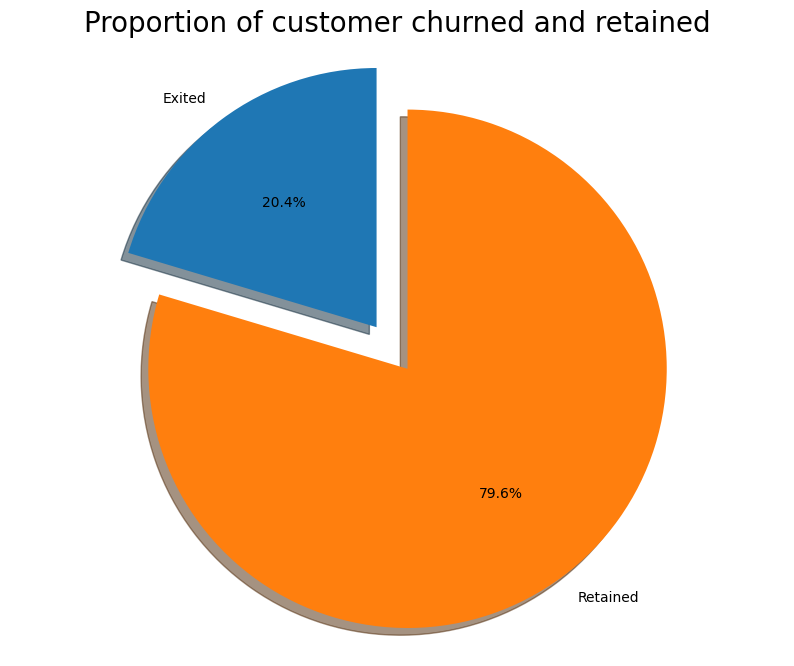

In [8]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.2)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

<AxesSubplot: xlabel='IsActiveMember', ylabel='count'>

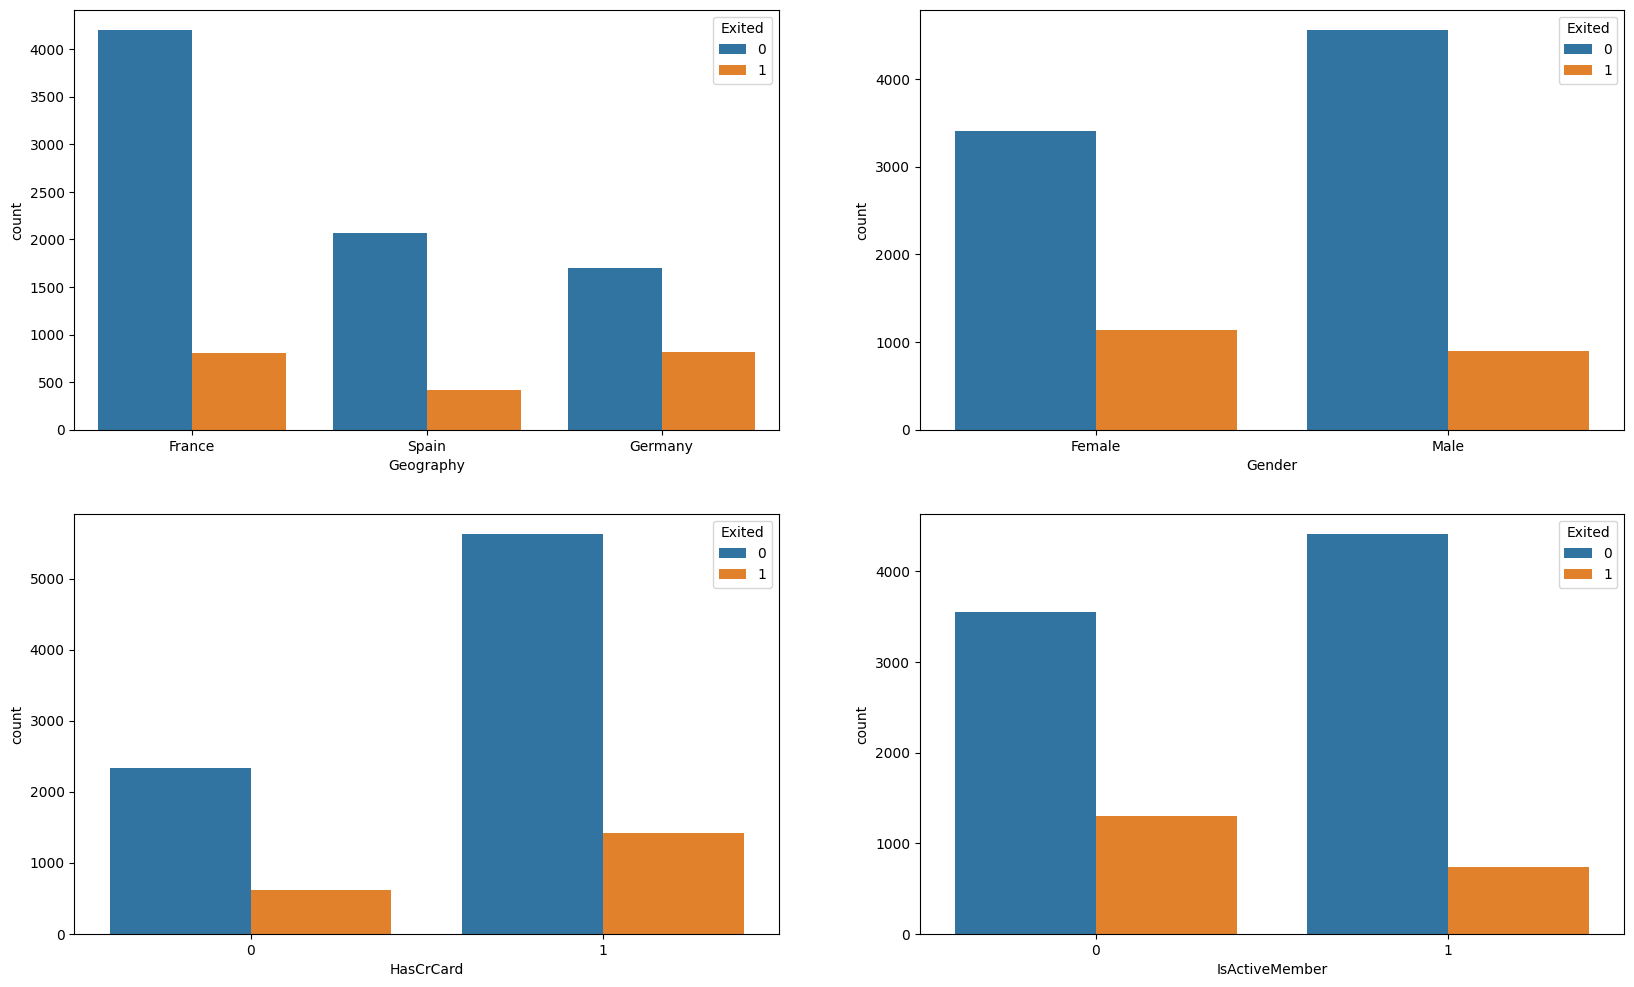

In [9]:
# We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

Notes:

- The vast majority of the data comes from French citizens. However, the percentage of churned customers is negatively correlated to the number of customers, suggesting that the bank may be experiencing difficulties (perhaps due to inadequate customer service staff) in locations where it has fewer consumers.
- Also, a higher percentage of women than men leave the company.
- It's interesting that customers that use credit cards make up the majority of churning customers. Given that the vast majority of clients use credit cards, this might just be a coincidence.
- Consequently, the churn rate is higher among inactive members. The overall percentage of inactive members is rather high, which is concerning and indicates that the bank may need to create a program to turn his group to active customers as this will definately have a positive impact on the customer churn.

<AxesSubplot: xlabel='Exited', ylabel='EstimatedSalary'>

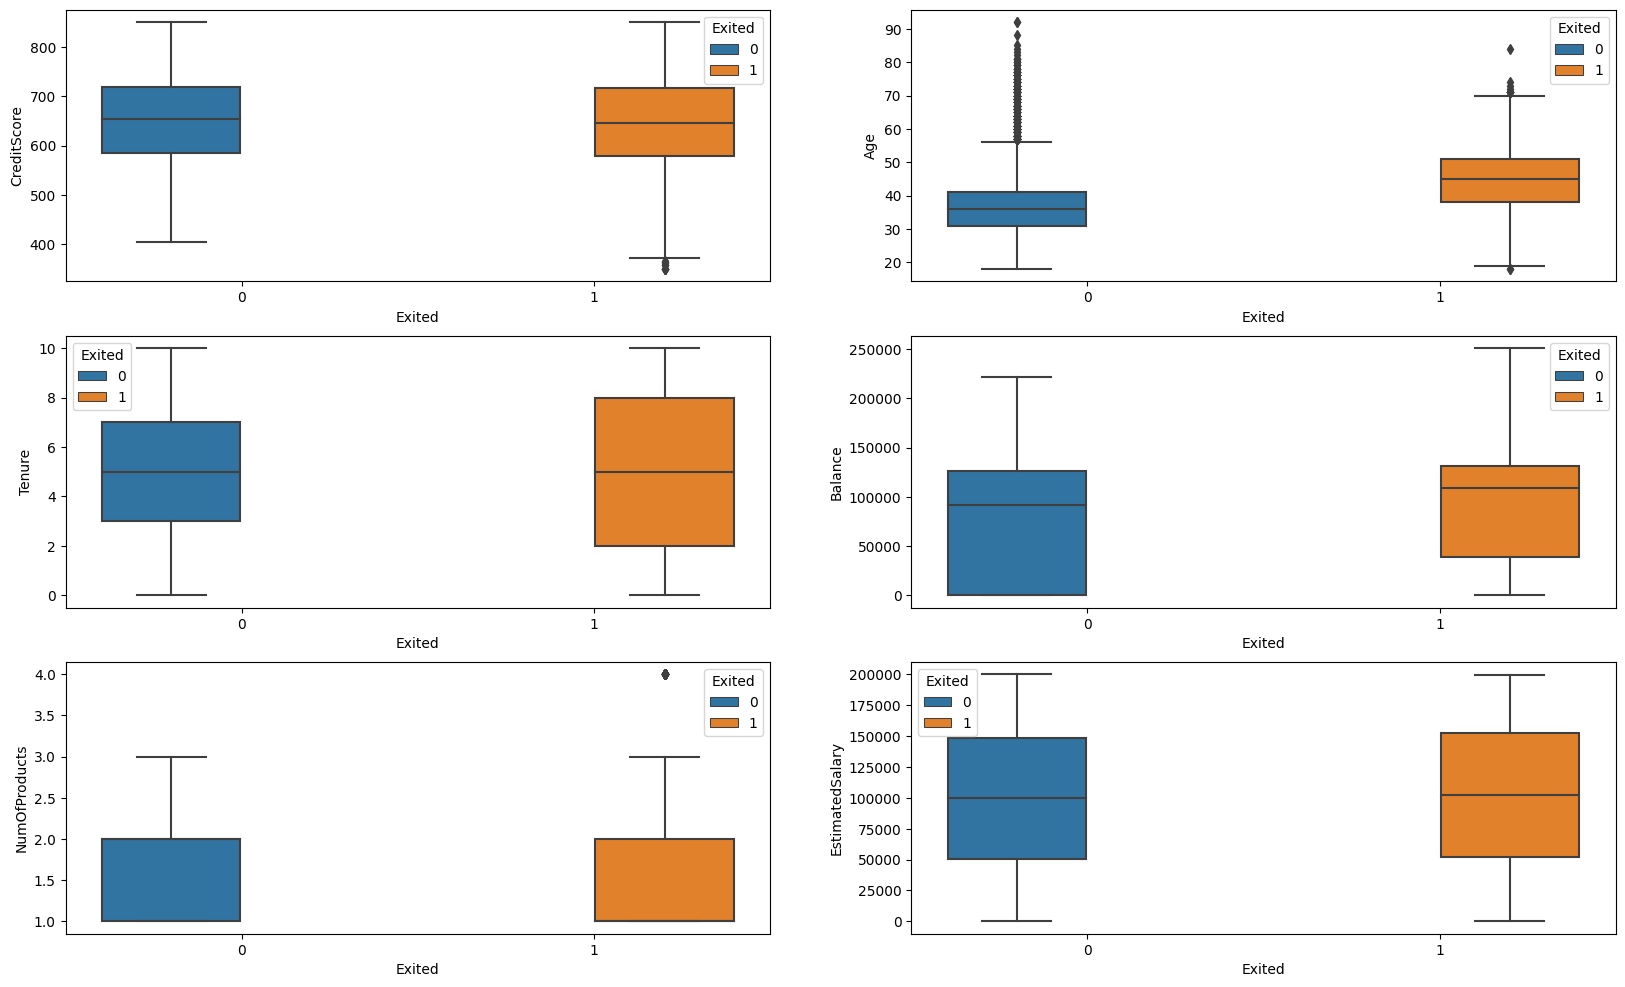

In [10]:
 # Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

Notes:

- The older customers are leaving more frequently than the younger ones, indicating that the two age groups have different service preferences. The bank might need to evaluate their target market or their retention strategy for the various age groups.
- Clients who have been with the bank for a short period of time or a long period of time are more likely to churn than those who have had an average length of time with the bank.

- Uncomfortably, the bank is losing clients that have sizable bank balances, which is likely to reduce their cash available for lending.
- The likelihood of turnover is not much influenced by the product or the wage.

**4. Feature engineering**

In [11]:
# Split Train, test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

8000
2000


(-1.0, 5.0)

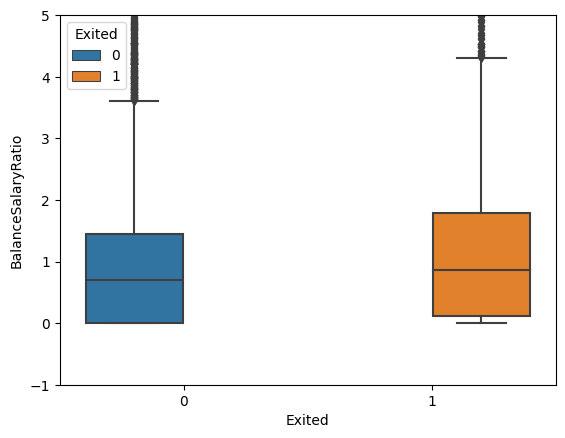

In [12]:
df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 5)

As we've shown, the salary has minimal bearing on the likelihood that a customer will leave. The ratio between the bank balance and the expected salary, as can be seen above, shows that customers with greater balance-to-estimated-salary ratios churn more frequently, which is concerning to the bank as it affects their supply of lending capital.

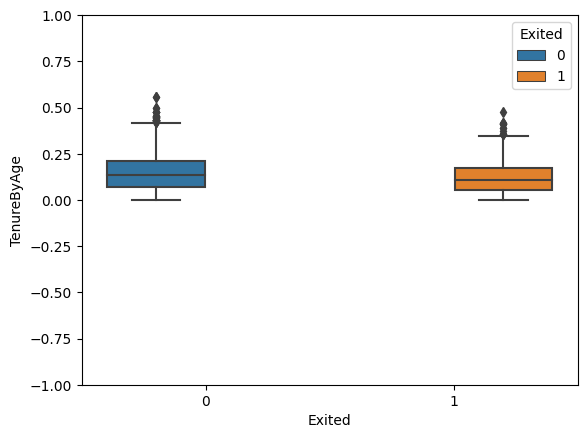

In [13]:
# Given that tenure is a 'function' of age, we introduce a variable aiming to standardize tenure over age:
df_train['TenureByAge'] = df_train.Tenure/(df_train.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 1)
plt.show()

In [14]:
# we also include age with relationship with credit score

df_train['CreditScoreGivenAge'] = df_train.CreditScore/(df_train.Age)

**5. Data prep for model fitting**

In [15]:
# Arrange columns by data type for easier manipulation
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df_train = df_train[['Exited'] + continuous_vars + cat_vars]
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,0,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,0,1,France,Male


In [16]:
'''For the one hot variables, we change 0 to -1 so that the models can capture a negative relation '''
df_train.loc[df_train.HasCrCard == 0, 'HasCrCard'] = -1
df_train.loc[df_train.IsActiveMember == 0, 'IsActiveMember'] = -1
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,France,Male


In [17]:
len(df_train['Gender'].unique())

2

Next we can one hot encode the categorical variables so as to make it easy for our machine learning models to understand them. Lets One hot encode without using the built in package.

While doing this we have to take care and handle multicollinearity. We have to remove the last one hot encoded variable to avoid this. For example, in Gender if we have a female category with 1 for male and -1 for female, then another column for male will not give any further information

In [ ]:
# One hot encode the categorical variables
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df_train[i].dtype == np.str or df_train[i].dtype == np.object):
        count = 0
        for j in df_train[i].unique():
            if count < len(df_train[i].unique())-1:
                print(j)
                print(count)
                df_train[i+'_'+j] = np.where(df_train[i] == j,1,-1)
                count += 1
        remove.append(i)
df_train = df_train.drop(remove, axis=1)
df_train.head()

In [20]:
# minMax scaling the continuous variables
minVec = df_train[continuous_vars].min().copy()
maxVec = df_train[continuous_vars].max().copy()
df_train[continuous_vars] = (df_train[continuous_vars]-minVec)/(maxVec-minVec)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Gender_Female
8159,0,0.222,0.094595,0.6,0.000000,0.333333,0.076118,0.000000,0.432000,0.323157,1,1,1,-1,1
6332,0,0.538,0.229730,0.4,0.360358,0.000000,0.102376,0.003317,0.205714,0.305211,1,1,-1,1,1
8895,0,0.698,0.297297,0.8,0.486406,0.000000,0.510225,0.000901,0.360000,0.300198,1,-1,-1,1,1
5351,0,0.416,0.310811,0.2,0.495130,0.000000,0.555744,0.000843,0.087805,0.208238,1,1,-1,-1,-1
4314,0,0.576,0.216216,0.5,0.532094,0.000000,0.778145,0.000647,0.264706,0.330882,-1,1,-1,1,-1


We have to perform the same steps on the test set also

In [21]:
def DfPrepPipeline(df_predict,df_train_Cols,minVec,maxVec):
    # Add new features
    df_predict['BalanceSalaryRatio'] = df_predict.Balance/df_predict.EstimatedSalary
    df_predict['TenureByAge'] = df_predict.Tenure/(df_predict.Age - 18)
    df_predict['CreditScoreGivenAge'] = df_predict.CreditScore/(df_predict.Age - 18)
    # Reorder the columns
    continuous_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
    cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"] 
    df_predict = df_predict[['Exited'] + continuous_vars + cat_vars]
    # Change the 0 in categorical variables to -1
    df_predict.loc[df_predict.HasCrCard == 0, 'HasCrCard'] = -1
    df_predict.loc[df_predict.IsActiveMember == 0, 'IsActiveMember'] = -1
    # One hot encode the categorical variables
    lst = ["Geography", "Gender"]
    remove = list()
    for i in lst:
        for j in df_predict[i].unique():
            df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
        remove.append(i)
    df_predict = df_predict.drop(remove, axis=1)
    # Ensure that all one hot encoded variables that appear in the train data appear in the subsequent data
    L = list(set(df_train_Cols) - set(df_predict.columns))
    for l in L:
        df_predict[str(l)] = -1        
    # MinMax scaling coontinuous variables based on min and max from the train data
    df_predict[continuous_vars] = (df_predict[continuous_vars]-minVec)/(maxVec-minVec)
    # Ensure that The variables are ordered in the same way as was ordered in the train set
    df_predict = df_predict[df_train_Cols]
    return df_predict

**6. Model fitting and selection**

In [22]:
# Support functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [23]:
# Function to give best model score and parameters
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

Next we shall try out each of the models and find the one with best performance

In [24]:
# Fit primal logistic regression
param_grid = {'C': [0.1,0.5,1,10,50,100], 'max_iter': [250], 'fit_intercept':[True],'intercept_scaling':[1],
              'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001]}
log_primal_Grid = GridSearchCV(LogisticRegression(solver='lbfgs'),param_grid, cv=10, refit=True, verbose=0)
log_primal_Grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(log_primal_Grid)

0.8149999999999998
{'C': 100, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'penalty': 'l2', 'tol': 1e-05}
LogisticRegression(C=100, max_iter=250, tol=1e-05)


In [25]:
# Fit logistic regression with degree 2 polynomial kernel
param_grid = {'C': [0.1,10,50], 'max_iter': [300,500], 'fit_intercept':[True],'intercept_scaling':[1],'penalty':['l2'],
              'tol':[0.0001,0.000001]}
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'Exited'])
log_pol2_Grid = GridSearchCV(LogisticRegression(solver = 'liblinear'),param_grid, cv=5, refit=True, verbose=0)
log_pol2_Grid.fit(df_train_pol2,df_train.Exited)
best_model(log_pol2_Grid)

0.8558749999999999
{'C': 50, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 300, 'penalty': 'l2', 'tol': 0.0001}
LogisticRegression(C=50, max_iter=300, solver='liblinear')


In [26]:
# Fit SVM with RBF Kernel
param_grid = {'C': [0.5,100,150], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['rbf']}
SVM_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
SVM_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(SVM_grid)

0.8542498391752044
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
SVC(C=100, gamma=0.1, probability=True)


In [27]:
# Fit SVM with pol kernel
param_grid = {'C': [0.5,1,10,50,100], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['poly'],'degree':[2,3] }
SVM_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
SVM_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(SVM_grid)

0.8523752610443575
{'C': 100, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly', 'probability': True}
SVC(C=100, gamma=0.1, kernel='poly', probability=True)


In [28]:
# Fit random forest classifier
param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]}
RanFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
RanFor_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(RanFor_grid)

0.8577499999999999
{'max_depth': 8, 'max_features': 6, 'min_samples_split': 3, 'n_estimators': 50}
RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3,
                       n_estimators=50)


In [29]:
# Fit Extreme Gradient boosting classifier
param_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, refit=True, verbose=0)
xgb_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(xgb_grid)

0.8618750000000001
{'gamma': 0.01, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 20}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


Fit best Models

In [33]:
# Fit primal logistic regression
log_primal = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=250, multi_class='auto',n_jobs=None, 
                                penalty='l2', random_state=None, solver='lbfgs',tol=1e-05, verbose=0, warm_start=False)
log_primal.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

LogisticRegression(C=100, max_iter=250, tol=1e-05)

In [35]:
# Fit logistic regression with pol 2 kernel
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'Exited'])
log_pol2 = LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=300, multi_class='auto', n_jobs=None, 
                              penalty='l2', random_state=None, solver='liblinear',tol=0.0001, verbose=0, warm_start=False)
log_pol2.fit(df_train_pol2,df_train.Exited)

LogisticRegression(C=50, max_iter=300, solver='liblinear')

In [36]:
# Fit SVM with RBF Kernel
SVM_RBF = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf', max_iter=-1, probability=True, 
              random_state=None, shrinking=True,tol=0.001, verbose=False)
SVM_RBF.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

SVC(C=100, gamma=0.1, probability=True)

In [31]:
# Fit SVM with Pol Kernel
SVM_POL = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',  max_iter=-1,
              probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)
SVM_POL.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

SVC(C=100, gamma=0.1, kernel='poly', probability=True)

In [37]:
# Fit Random Forest classifier
RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=8, max_features=6, max_leaf_nodes=None,min_impurity_decrease=0.0,min_samples_leaf=1, min_samples_split=3,min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                            oob_score=False, random_state=None, verbose=0,warm_start=False)
RF.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3,
                       n_estimators=50)

In [45]:
# Fit Extreme Gradient Boost Classifier
XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=1, n_estimators=20,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1)
XGB.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

[15:03:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.01, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=7, max_leaves=None, min_child_weight=5, missing=1,
              monotone_constraints=None, n_estimators=20, n_jobs=1,
              nthread=None, num_parallel_tree=None, predictor=None, ...)

**Review best model fit accuracy : Keen interest is on the performance in predicting 1's (Customers who churn)**

In [39]:
print(classification_report(df_train.Exited,log_primal.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      6353
           1       0.64      0.24      0.35      1647

    accuracy                           0.82      8000
   macro avg       0.74      0.60      0.62      8000
weighted avg       0.79      0.82      0.78      8000



In [40]:
print(classification_report(df_train.Exited,log_pol2.predict(df_train_pol2)))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      6353
           1       0.76      0.48      0.59      1647

    accuracy                           0.86      8000
   macro avg       0.82      0.72      0.75      8000
weighted avg       0.85      0.86      0.85      8000



In [41]:
print(classification_report(df_train.Exited,SVM_RBF.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6353
           1       0.85      0.40      0.54      1647

    accuracy                           0.86      8000
   macro avg       0.85      0.69      0.73      8000
weighted avg       0.86      0.86      0.84      8000



In [42]:
print(classification_report(df_train.Exited,SVM_POL.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6353
           1       0.86      0.37      0.52      1647

    accuracy                           0.86      8000
   macro avg       0.86      0.68      0.72      8000
weighted avg       0.86      0.86      0.84      8000



In [43]:
print(classification_report(df_train.Exited,RF.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      6353
           1       0.87      0.48      0.62      1647

    accuracy                           0.88      8000
   macro avg       0.88      0.73      0.77      8000
weighted avg       0.88      0.88      0.86      8000



In [46]:
print(classification_report(df_train.Exited,XGB.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.88      0.97      0.93      6353
           1       0.82      0.51      0.63      1647

    accuracy                           0.88      8000
   macro avg       0.85      0.74      0.78      8000
weighted avg       0.87      0.88      0.86      8000



In [47]:
y = df_train.Exited
X = df_train.loc[:, df_train.columns != 'Exited']
X_pol2 = df_train_pol2
auc_log_primal, fpr_log_primal, tpr_log_primal = get_auc_scores(y, log_primal.predict(X),log_primal.predict_proba(X)[:,1])
auc_log_pol2, fpr_log_pol2, tpr_log_pol2 = get_auc_scores(y, log_pol2.predict(X_pol2),log_pol2.predict_proba(X_pol2)[:,1])
auc_SVM_RBF, fpr_SVM_RBF, tpr_SVM_RBF = get_auc_scores(y, SVM_RBF.predict(X),SVM_RBF.predict_proba(X)[:,1])
auc_SVM_POL, fpr_SVM_POL, tpr_SVM_POL = get_auc_scores(y, SVM_POL.predict(X),SVM_POL.predict_proba(X)[:,1])
auc_RF, fpr_RF, tpr_RF = get_auc_scores(y, RF.predict(X),RF.predict_proba(X)[:,1])
auc_XGB, fpr_XGB, tpr_XGB = get_auc_scores(y, XGB.predict(X),XGB.predict_proba(X)[:,1])

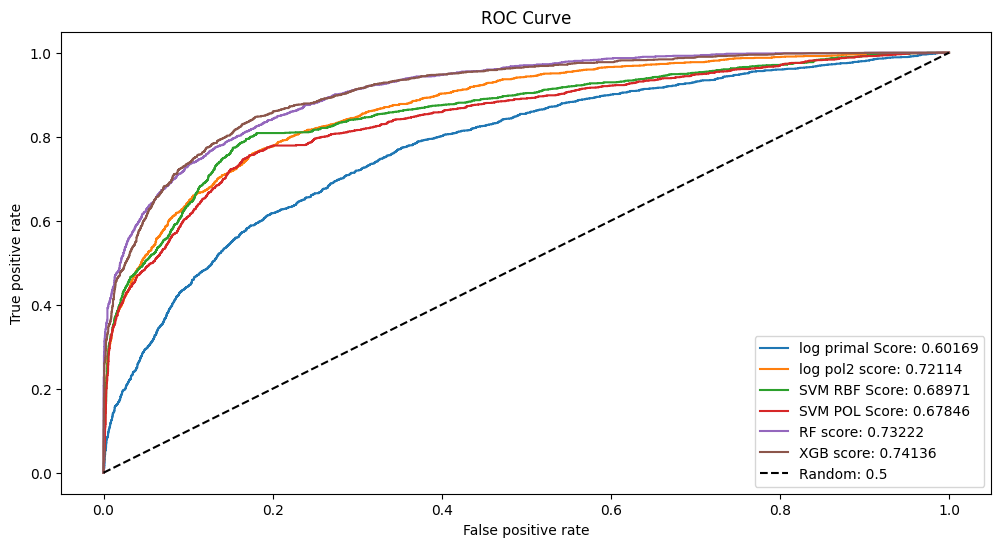

In [48]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_log_primal, tpr_log_primal, label = 'log primal Score: ' + str(round(auc_log_primal, 5)))
plt.plot(fpr_log_pol2, tpr_log_pol2, label = 'log pol2 score: ' + str(round(auc_log_pol2, 5)))
plt.plot(fpr_SVM_RBF, tpr_SVM_RBF, label = 'SVM RBF Score: ' + str(round(auc_SVM_RBF, 5)))
plt.plot(fpr_SVM_POL, tpr_SVM_POL, label = 'SVM POL Score: ' + str(round(auc_SVM_POL, 5)))
plt.plot(fpr_RF, tpr_RF, label = 'RF score: ' + str(round(auc_RF, 5)))
plt.plot(fpr_XGB, tpr_XGB, label = 'XGB score: ' + str(round(auc_XGB, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

According to the aforementioned findings, my primary goal is to identify potential churning clients so that I may place them in some form of churn prevention scheme. As a result, the recall metrics on the 1's are more significant to me than the model's overall accuracy rating.

A recall above this baseline will already be an improvement given that in the data we only had 20% of churn, but we want to get as high as possible while attempting to maintain a high precision so that the bank can train its resources effectively towards clients highlighted by the model without wasting too much resources on the false positives.

According to the fit on the training set, the XGB is the best model that provides a good balance of recall and precision. With a precision score on 1s of 0.82, out of all customers the model predicts will churn, 82% actually do, and with a recall score on 1s of 0.51, the model is able to highlight 51% of all those who churn.

In [49]:
# Make the data transformation for test data
df_test = DfPrepPipeline(df_test,df_train.columns,minVec,maxVec)
df_test = df_test.mask(np.isinf(df_test))
df_test = df_test.dropna()
df_test.shape

C:\Users\19176\AppData\Local\Temp\ipykernel_15412\4267285708.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
C:\Users\19176\AppData\Local\Temp\ipykernel_15412\4267285708.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
C:\Users\19176\AppData\Local\Temp\ipykernel_15412\4267285708.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

(1996, 15)

In [50]:
print(classification_report(df_test.Exited,  RF.predict(df_test.loc[:, df_test.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1607
           1       0.80      0.40      0.54       389

    accuracy                           0.86      1996
   macro avg       0.83      0.69      0.73      1996
weighted avg       0.86      0.86      0.85      1996



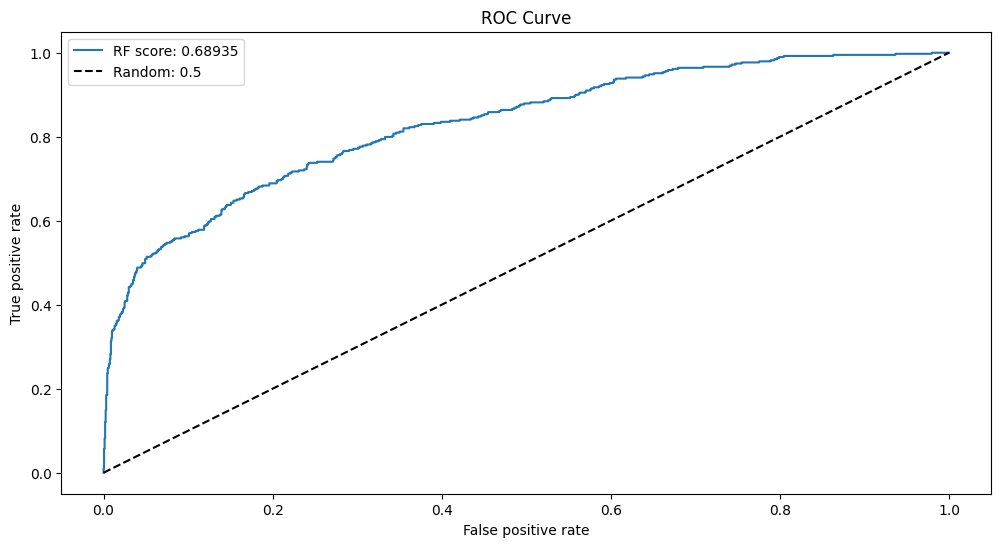

In [51]:
auc_RF_test, fpr_RF_test, tpr_RF_test = get_auc_scores(df_test.Exited, RF.predict(df_test.loc[:, df_test.columns != 'Exited']),
                                                       RF.predict_proba(df_test.loc[:, df_test.columns != 'Exited'])[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RF_test, tpr_RF_test, label = 'RF score: ' + str(round(auc_RF_test, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()